# Logistic Regression as a Single Neuron Model

## Imports

In [1]:
import numpy as np
import h5py
import requests
import os
import matplotlib.pyplot as plt

## Helper Functions

**Just run this cell - no need to go through the code in helper functions**

In [2]:
def download_file(url, local_filename):
    """
    Downloads a file from a URL and saves it locally.
    """
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_filename, 'wb') as f:
                f.write(response.content)
            print(f"File downloaded: {local_filename}")
        else:
            raise Exception(f"Failed to download file from {url}. Status code: {response.status_code}")
    else:
        print(f"File already exists: {local_filename}")

def load_dataset():
    # URLs of the .h5 files
    train_url = 'https://github.com/PyDataGBC/PyML2025/raw/refs/heads/main/LabWeek2/dataset/train_catvnoncat.h5'
    test_url = 'https://github.com/PyDataGBC/PyML2025/raw/refs/heads/main/LabWeek2/dataset/test_catvnoncat.h5'

    # Local file paths
    train_file = 'train_catvnoncat.h5'
    test_file = 'test_catvnoncat.h5'

    # Download the files if not already present
    download_file(train_url, train_file)
    download_file(test_url, test_file)

    # Open the files using h5py
    train_dataset = h5py.File(train_file, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # Train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # Train set labels

    test_dataset = h5py.File(test_file, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # Test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # Test set labels

    classes = np.array(test_dataset["list_classes"][:])  # List of classes

    # Reshape labels
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Importing Dataset

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

File downloaded: train_catvnoncat.h5
File downloaded: test_catvnoncat.h5


**Sanity Check:** print the shape of train and test features and labels. Also print `classes` variable.

In [4]:
print("train_set_x_orig shape:", train_set_x_orig.shape)
print("train_set_y shape:", train_set_y.shape)
print("test_set_x_orig shape:", test_set_x_orig.shape)
print("test_set_y shape:", test_set_y.shape)

print("classes raw:", classes)
print("classes decoded:", [c.decode("utf-8") for c in classes])

train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
classes raw: [b'non-cat' b'cat']
classes decoded: ['non-cat', 'cat']


## Data Visualization

label:  [1]


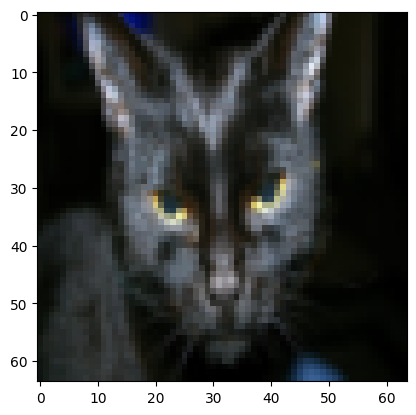

In [5]:
# Example of a picture
index = 25   # select a number between 0 and 208
#index = np.random.randint(0, 200)  # you can also generate a random number and see the different imagge each time
plt.imshow(train_set_x_orig[index])
print("label: ", train_set_y[:, index])

### **Exercise 1:** Take a look at five different images in train/test set. Try to see both cat and non-cat samples.

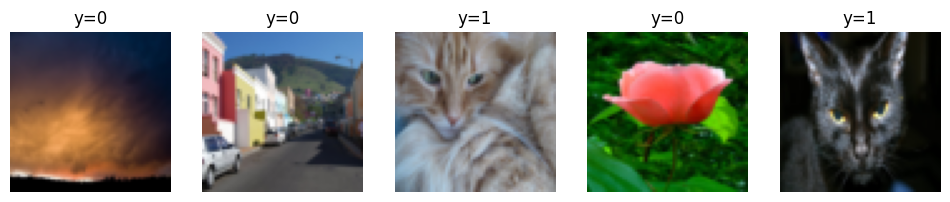

In [6]:
import matplotlib.pyplot as plt

# Pick some indices (change if you want)
indices = [0, 1, 2, 3, 25]

plt.figure(figsize=(12, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, len(indices), i+1)
    plt.imshow(train_set_x_orig[idx])
    plt.axis("off")
    plt.title(f"y={train_set_y[0, idx]}")
plt.show()


### **Exercise 2:** Print `train_set_y` array to see the labels of the data. What percentage of the pictures in `train set` contain cats?

In [7]:
print(train_set_y)

percent_cats = np.mean(train_set_y) * 100
print(f"Percent of cats in train set: {percent_cats:.2f}%")


[[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]
Percent of cats in train set: 34.45%


## Data Pre-processing

### Brief Theory: Numerical Representation of Images

![preprocessing](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/imvectorkiank.png)

### **Example 1:** Numerical Representation of an Image

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/imtovec_example.webp)

#### Step 1: Numerical representation of each channel (`MATRIX` format)

In [8]:
red_channel = np.array([[255, 123, 135], [44, 12, 15], [56, 87, 90]]) # 2d array: Matrix
green_channel = np.array([[255, 133, 175], [24, 123, 169], [98, 66, 77]])
blue_channel = np.array([[66, 54, 88], [55, 98, 54], [87, 142, 89]])

print("Red Channel")
print(red_channel.shape)
print(red_channel)

print("Green Channel")
print(green_channel.shape)
print(green_channel)

print("Bue Channel")
print(blue_channel.shape)
print(blue_channel)



Red Channel
(3, 3)
[[255 123 135]
 [ 44  12  15]
 [ 56  87  90]]
Green Channel
(3, 3)
[[255 133 175]
 [ 24 123 169]
 [ 98  66  77]]
Bue Channel
(3, 3)
[[ 66  54  88]
 [ 55  98  54]
 [ 87 142  89]]


#### Step 2: Putting the channels together in the form of a `TENSOR`

In [9]:
print("channel, height, width")
airplane_image = np.array([red_channel, green_channel, blue_channel])  # 3d array: Tensor
print(airplane_image.shape)
print(airplane_image)

channel, height, width
(3, 3, 3)
[[[255 123 135]
  [ 44  12  15]
  [ 56  87  90]]

 [[255 133 175]
  [ 24 123 169]
  [ 98  66  77]]

 [[ 66  54  88]
  [ 55  98  54]
  [ 87 142  89]]]


#### Step 3: Flatten the `tensor` into a `VECTOR`

In [10]:
airplane_flatten = airplane_image.flatten()   # 1d array: Vector
print(airplane_flatten.shape)
print(airplane_flatten)

(27,)
[255 123 135  44  12  15  56  87  90 255 133 175  24 123 169  98  66  77
  66  54  88  55  98  54  87 142  89]


### **Exercise 3:** Take one sample form train set again and check the shape of it. Try to interpret the numbers in the `shape`. Which axis corresponds to the `channel`, and which ones represent the `height` and `width` of the image?

**Notes:**
- The images are 64x64 `pixels`.
- There are 3 RGB `channels`.

sample_image shape: (64, 64, 3)


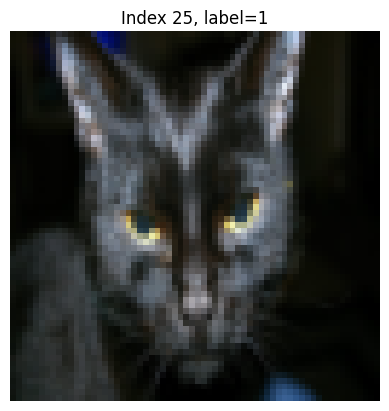

In [11]:
sample_index = 25
sample_image = train_set_x_orig[25]

print("sample_image shape:", sample_image.shape)

# Optional: show it
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Index {sample_index}, label={train_set_y[0, sample_index]}")
plt.show()


### **Exercise 4:** Fallaten the this sample image? what is the size of the flattened image? why this number?

In [12]:
flat = sample_image.flatten()
print("Flattened shape:", flat.shape)
print("Flattened size:", flat.size)

# Explanation (number should be 64*64*3 = 12288)
print("Expected:", 64*64*3)


Flattened shape: (12288,)
Flattened size: 12288
Expected: 12288


### **Exercise 5:** print the shape of the `train_set_x_orig`. Identify and explain what each value in the resulting tuple represents (e.g., number of training examples, image height, etc.).

In [13]:
print("train_set_x_orig:", train_set_x_orig.shape)
print("train_set_y:", train_set_y.shape)
print("test_set_x_orig:", test_set_x_orig.shape)
print("test_set_y:", test_set_y.shape)


train_set_x_orig: (209, 64, 64, 3)
train_set_y: (1, 209)
test_set_x_orig: (50, 64, 64, 3)
test_set_y: (1, 50)


### **Data Preprocessing:** Flattening the entrie Train and Test Datasets

**Note:** We're going to talk about the details of the following code in next sessions. For now just pay attentin to the output shapes of data.

In [14]:
X_train = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
print("Train set shape: ", X_train.shape)

X_test = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
print("Test set shape: ", X_test.shape)

y_train = train_set_y[0]
print("Train label shape: ", y_train.shape)

y_test = test_set_y[0]
print("Test label shape: ", y_test.shape)



Train set shape:  (209, 12288)
Test set shape:  (50, 12288)
Train label shape:  (209,)
Test label shape:  (50,)


**Important Notes:**
- We have 209 samples in the train set, and
- 50 samples in the test set.
- each sample has 64x64x3=12288 `features`. So each pixel can be considered as one feature.
- remember that we had `4` features in `IRIS` dataset and now we have more than `10,000` features.

## Implementing Logistic Regression

This is what happens under the hood when you use the `LogisticRegression` classifier in scikit-learn.

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/LogReg_kiank.png)

### **Exercise 6:** What is the label in the following hypothetical input?

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/toyexample.png)

### **The Sigmoid Function**

The sigmoid function is defined by the formula:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

In [15]:
z = 10*(-0.5) + 5*(1) + 3*(0.7) + 1*(-0.1)
sigmoid = 1 / (1 + np.exp(-z))

print("z =", z)
print("sigmoid(z) =", sigmoid)

label = 1 if sigmoid >= 0.5 else 0
print("predicted label =", label)


z = 1.9999999999999996
sigmoid(z) = 0.8807970779778823
predicted label = 1


### **Exercise 7:** Train a `LogisticRegression` classifier to run a binary classification on the flattened cat pictures.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [19]:
# Normalize pixel values
X_train_norm = X_train / 255.0
X_test_norm  = X_test / 255.0

model = LogisticRegression(max_iter=2000)
model.fit(X_train_norm, y_train)

y_pred_train = model.predict(X_train_norm)
y_pred_test  = model.predict(X_test_norm)

print("Training done.")


Training done.


### **Exercise 8:** Evaluate your model manually

1. Choose a random index of an image.
2. Display the image.
3. Print the original label.
4. Print the predicted label.
5. Repeat this process multiple times to identify which pictures are more challenging for the model.

Test idx 0: predicted=1, true=1


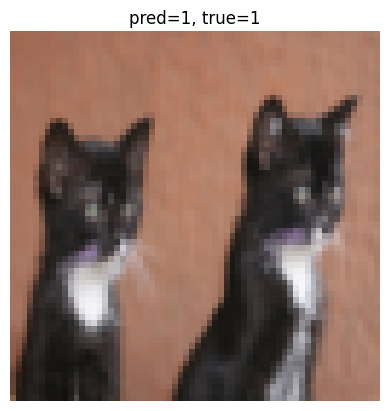

Test idx 5: predicted=0, true=0


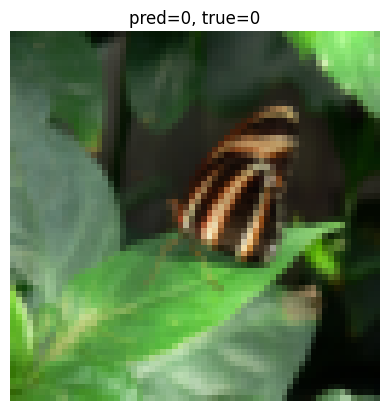

Test idx 10: predicted=0, true=1


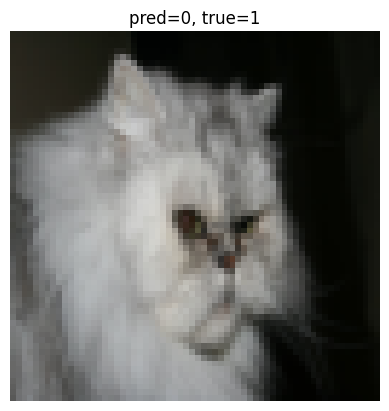

Test idx 15: predicted=1, true=1


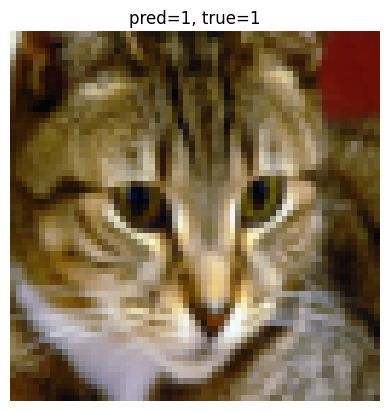

In [20]:
# Show a few test predictions manually
sample_ids = [0, 5, 10, 15]

for idx in sample_ids:
    pred = model.predict(X_test_norm[idx:idx+1])[0]
    true = y_test[idx]
    print(f"Test idx {idx}: predicted={pred}, true={true}")

    plt.imshow(test_set_x_orig[idx])
    plt.axis("off")
    plt.title(f"pred={pred}, true={true}")
    plt.show()


### **Exercise 9:** Report the overall accuracy of your classifier

In [21]:
train_acc = accuracy_score(y_train, y_pred_train)
test_acc  = accuracy_score(y_test, y_pred_test)

print(f"Train accuracy: {train_acc*100:.2f}%")
print(f"Test accuracy:  {test_acc*100:.2f}%")


Train accuracy: 100.00%
Test accuracy:  70.00%


## MNIST dataset (Exercise 10-13) - Optional, if you have extra time

In [22]:
#import mnist dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
x_train.shape

(60000, 28, 28)

Label:  4
Image Shape:  (28, 28)


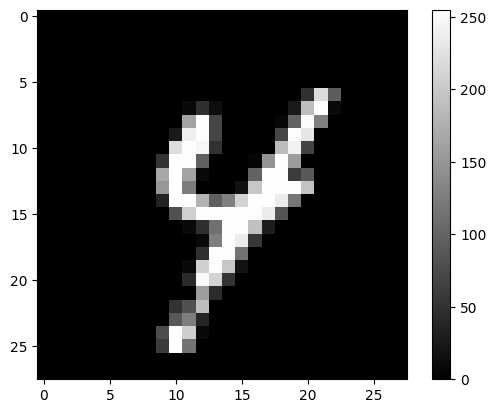

In [33]:
#Note: Run this cell multiple times
index = np.random.randint(0, x_train.shape[0])
print("Label: ", y_train[index])
print("Image Shape: ", x_train[index].shape)
plt.imshow(x_train[index], cmap='gray')
plt.colorbar()

### **Excercise 10:** What is the difference between a black-and-white image and a color image in terms of numerical representation?

### Hint: check the number of channels in the two types of images.

your answer here: Black & white (grayscale) image → usually a 2D matrix (height × width), each pixel is one number (often 0–255).

Color image → usually a 3D tensor (height × width × 3) for RGB channels.


### **Exercise 11:** Select one data sample and flatten it. What is the size of the flattened image and why?

In [34]:
mnist_sample = x_train[0]
flat_mnist = mnist_sample.flatten()

print("Original shape:", mnist_sample.shape)
print("Flattened shape:", flat_mnist.shape)
print("Flattened size:", flat_mnist.size)  # 28*28 = 784


Original shape: (28, 28)
Flattened shape: (784,)
Flattened size: 784


### **Excercise 12:** Flatten the images in Train and Test Datasets so that each image is a 1D array

In [35]:
X_train_mnist = x_train.reshape(x_train.shape[0], -1) / 255.0
X_test_mnist  = x_test.reshape(x_test.shape[0], -1) / 255.0

print("X_train_mnist:", X_train_mnist.shape)
print("X_test_mnist:", X_test_mnist.shape)


X_train_mnist: (60000, 784)
X_test_mnist: (10000, 784)


### **Excercise 13:** Implement Logistic Regression on MNIST dataset using scikit-learn. What is the accuracy of your model?

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time

mnist_model = LogisticRegression(
    max_iter=500,          # lower
    solver="saga",         # faster for large data
    multi_class="multinomial",
    n_jobs=-1              # use all CPU cores
)

# Train on a subset (fast)
t0 = time.time()
mnist_model.fit(X_train_mnist[:20000], y_train[:20000])
print("Train seconds:", round(time.time() - t0, 2))

# Test on a subset (fast)
preds = mnist_model.predict(X_test_mnist[:5000])
print("Accuracy (subset):", round(accuracy_score(y_test[:5000], preds) * 100, 2), "%")



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


KeyboardInterrupt: 